In [25]:
%load_ext autoreload
%autoreload 2
import sys
# from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
# import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
# import sasc.viz
import joblib
# import dvu
from tqdm import tqdm
import sys
sys.path.append('../notebooks')
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import viz
from neurosynth import term_dict, term_dict_rev
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

# Load "groundtruth" comparisons

### load neurosynth avg. flatmaps

In [26]:
def get_neurosynth_flatmaps(subject, neurosynth_dir='/home/chansingh/mntv1/deep-fMRI/qa/neurosynth_data'):
    subject_s = subject.replace('UT', '')
    # neurosynth_dir = '/home/chansingh/mntv1/deep-fMRI/qa/neurosynth_data/all_association-test_z'

    term_names = [k.replace('.nii.gz', '').replace(
        '_association-test_z', '') for k in os.listdir(join(neurosynth_dir, f'all_in_{subject_s}-BOLD'))]

    # filter dict for files that were in neurosynth
    term_dict_ = {k: v for k, v in term_dict.items() if k in term_names}
    # for k in term_dict.keys():
    #     if k not in term_names:
    #         print(k)

    # filter dict for files that had questions run
    questions_run = [k.replace('.pkl', '') for k in os.listdir(
        '/home/chansingh/mntv1/deep-fMRI/qa/cache_gpt')]
    term_dict_ = {k: v for k, v in term_dict_.items() if v in questions_run}

    def _load_flatmap(term, neurosynth_dir, subject):
        # output_file = join(neurosynth_dir, f'{term}_association-test_z.nii.gz')
        output_file = join(
            neurosynth_dir, f'all_in_{subject_s}-BOLD/{term}.nii.gz')
        vol = cortex.Volume(output_file, subject, subject + '_auto').data
        mask = cortex.db.get_mask(subject, subject + '_auto')
        return vol[mask]

    return {q: _load_flatmap(
        term, neurosynth_dir, subject) for (term, q) in term_dict_.items()}

### compute correlations with qa flatmaps and plot avgs

In [27]:
def plot_corrs_err_subjects(corrs_df, setting, xlab):

    plt.figure(figsize=(7, 5))
    colors = {
        'UTS01': 'C0',
        'UTS02': 'C1',
        'UTS03': 'C2',
        'mean': 'black'
    }

    d_mean = pd.DataFrame(corrs_df.groupby('questions')[
        'corrs'].mean()).reset_index()
    d_mean['subject'] = 'mean'
    corrs_df = pd.concat([corrs_df, d_mean])
    corrs_df = corrs_df.set_index('questions')

    for subject in ['mean', 'UTS01', 'UTS02', 'UTS03']:
        r_df = corrs_df[corrs_df['subject'] == subject]
        if subject == 'mean':
            idx_sort = r_df['corrs'].sort_values(ascending=False).index

        r_df = r_df.loc[idx_sort]

        # plot corrs
        if subject == 'mean':
            plt.errorbar(
                r_df['corrs'],
                range(len(r_df)),
                color='black',
                fmt='o',
                zorder=1000,
                label=subject.capitalize(),
            )
        else:
            plt.errorbar(
                r_df['corrs'],
                range(len(r_df)),
                # xerr=np.sqrt(
                # r_df['corrs'] * (1-r_df['corrs'])
                # / r_df['num_test']),
                alpha=0.5,
                label=subject.upper(),
                fmt='o')
        plt.axvline(r_df['corrs'].mean(),
                    linestyle='--', color=colors[subject], zorder=-1000)

        print('mean corr', r_df['corrs'].mean())

    # add horizontal bars
    plt.yticks(range(len(r_df)), [term_dict_rev[k] for k in idx_sort])
    plt.xlabel(xlab, fontsize='large')
    plt.grid(axis='y', alpha=0.2)
    plt.axvline(0, color='gray')

    abs_lim = max(np.abs(plt.xlim()))
    plt.xlim(-abs_lim, abs_lim)

    # annotate with baseline and text label
    plt.legend(fontsize='large')
    plt.tight_layout()
    plt.savefig(join(repo_dir, 'qa_results',
                'neurosynth', 'corrs_' + setting + '.png'), dpi=300)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:47<00:00, 15.79s/it]


mean corr 0.08744538938801583
mean corr 0.08641528421718801
mean corr 0.0698062046487559
mean corr 0.10611467929810357


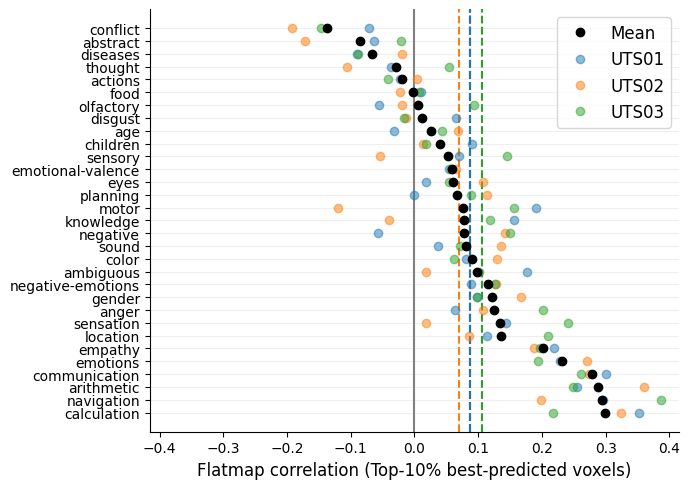

In [31]:
# setting = 'shapley_neurosynth'
# setting = 'full_neurosynth'

apply_mask = True
frac_voxels_to_keep = 0.10


corrs_df_list = defaultdict(list)
for subject in tqdm(['UTS01', 'UTS02', 'UTS03']):
    flatmaps_gt = get_neurosynth_flatmaps(subject)

    flatmaps_qa_list = defaultdict(list)
    # , 'individual_neurosynth']:
    # for setting in ['shapley_neurosynth', 'full_neurosynth', 'individual_gpt4']:
    for setting in ['individual_gpt4', 'individual_gpt4', 'shapley_neurosynth']:
        flatmaps_qa = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa.keys():
            flatmaps_qa_list[q].append(flatmaps_qa[q])
    flatmaps_qa = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()}

    if apply_mask:
        corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
            'UT', ''), 'corrs_test_35.pkl')).values[0]
        # threshold top-20%
        corrs_test_mask = (corrs_test > np.percentile(
            corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)
        flatmaps_qa = {k: flatmaps_qa[k][corrs_test_mask]
                       for k in flatmaps_qa.keys()}
        flatmaps_gt = {k: flatmaps_gt[k][corrs_test_mask]
                       for k in flatmaps_gt.keys()}

    # get common flatmaps and put into d
    common_keys = set(flatmaps_gt.keys()) & set(
        flatmaps_qa.keys())
    d = defaultdict(list)
    for k in common_keys:
        d['questions'].append(k)
        d['corr'].append(np.corrcoef(flatmaps_qa[k],
                                     flatmaps_gt[k])[0, 1])
        d['flatmap_qa'].append(flatmaps_qa[k])
        d['flatmap_neurosynth'].append(flatmaps_gt[k])
    d = pd.DataFrame(d).sort_values('corr', ascending=False)

    corrs = viz._calc_corrs(
        d['flatmap_qa'].values,
        d['flatmap_neurosynth'].values,
        titles_qa=d['questions'].values,
        titles_gt=d['questions'].values,
    )

    corrs_df_list['corrs'].extend(np.diag(corrs).tolist())
    corrs_df_list['questions'].extend(d['questions'].values.tolist())
    corrs_df_list['subject'].extend([subject] * len(d['questions'].values))

    # viz.corr_bars(
    #     corrs,
    #     out_dir_save=join(repo_dir, 'qa_results', 'neurosynth', setting),
    #     xlab='Neurosynth',
    # )

    # save flatmaps
    # for i in tqdm(range(len(d))):
    #     sasc.viz.quickshow(
    #         d.iloc[i]['flatmap_qa'],
    #         subject=subject,
    #         fname_save=join(repo_dir, 'qa_results', 'neurosynth', subject,
    #                         setting, f'{d.iloc[i]["questions"]}.png')
    #     )

    #     sasc.viz.quickshow(
    #         d.iloc[i]['flatmap_neurosynth'],
    #         subject=subject,
    #         fname_save=join(repo_dir, 'qa_results', 'neurosynth', subject,
    #                         'neurosynth', f'{d.iloc[i]["questions"]}.png')
    #     )
corrs_df = pd.DataFrame(corrs_df_list)
# corrs_df.to_pickle(join(repo_dir, 'qa_results',
#    'neurosynth', setting + '_corrs_df.pkl'))

plot_corrs_err_subjects(
    corrs_df, setting, xlab=f'Flatmap correlation (Top-{int(100*frac_voxels_to_keep)}% best-predicted voxels)')
plt.savefig('neurosynth_correlation.png', dpi=300)

# Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results',
                               'neurosynth', setting + '_corrs_df.pkl'))

In [ ]:
setting = 'shapley_neurosynth'
for subject in ['UTS01', 'UTS02', 'UTS03']:
    img_dir1 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, 'neurosynth')
    img_dir2 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, setting)

    # read images and combine them with their filenames on a single plot
    # fnames = os.listdir(img_dir1)
    # fnames = [f for f in fnames if f.endswith('.png')]
    # only keep the ones that are in both directories
    # fnames = [f for f in fnames if f in os.listdir(img_dir2)]

    corrs = corrs_df[corrs_df['subject'] == subject]
    # corrs = corrs.sort_values('corrs', ascending=False)
    fnames = [v + '.png' for v in corrs['questions'].values]

    n = len(fnames)
    C = 4
    R = int(np.ceil(n / C))

    fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
    axs = axs.flatten()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i, fname in enumerate(fnames):
        img1 = plt.imread(join(img_dir1, fname))
        img2 = plt.imread(join(img_dir2, fname))
        axs[i].imshow(np.concatenate([img1, img2], axis=1))
        axs[i].set_title(
            f'{term_dict_rev[fname[:-4]]} ({corrs["corrs"].values[i]:0.3f})', fontsize=8)

    # add text in bottom right of figure
    fig.text(0.99, 0.01, f'{subject}\nNeurosynth on left, QA on right',
             ha='right', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(join(repo_dir, 'qa_results', 'neurosynth',
                subject, f'flatmaps_{setting}_{subject}.png'), dpi=300)
    plt.close()